# Import Library

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 22.6 MB/s eta 0:00:00


In [2]:
!pip install -U ipywidgets

In [3]:
from ultralytics import YOLO
import os  
import pandas as pd  
import numpy as np  
import cv2  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split 
from glob import glob  
 
from PIL import Image


import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Create necessary directories
!mkdir -p "/kaggle/working/data"
!mkdir -p "/kaggle/working/data/images"
!mkdir -p "/kaggle/working/data/images/train"
!mkdir -p "/kaggle/working/data/images/val"
!mkdir -p "/kaggle/working/data/labels"
!mkdir -p "/kaggle/working/data/labels/train"
!mkdir -p "/kaggle/working/data/labels/val"

root_dir = "/kaggle/working/data"
labels_dir = "/kaggle/working/data/labels"
images_dir = "/kaggle/working/data/images"

In [5]:
# Define paths
train_data = "/kaggle/input/car-object-detection/data/training_images"
csv_data = "/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"
test_data = "/kaggle/input/car-object-detection/data/testing_images"

In [6]:
# Loading the CSV data
df = pd.read_csv(csv_data)

# Display the first few rows of the dataframe to understand its structure
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB
None


In [8]:
# Visualizing sample images with bounding boxes
def plot_images_with_boxes(image_path, df, n=5):
    images = glob(f'{image_path}/*.jpg')[:n]
    for img_path in images:
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        boxes = df[df['image'] == img_name]  # تغيير 'filename' إلى 'image'
        
        for _, box in boxes.iterrows():
            cv2.rectangle(img, 
                          (int(box['xmin']), int(box['ymin'])), 
                          (int(box['xmax']), int(box['ymax'])), 
                          (0, 255, 0), 2)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_name)
        plt.axis('off')
        plt.show()

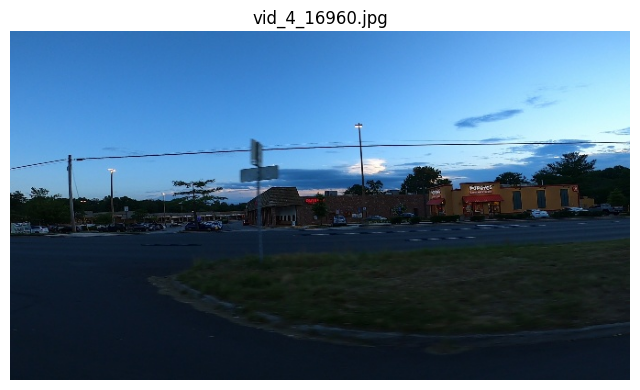

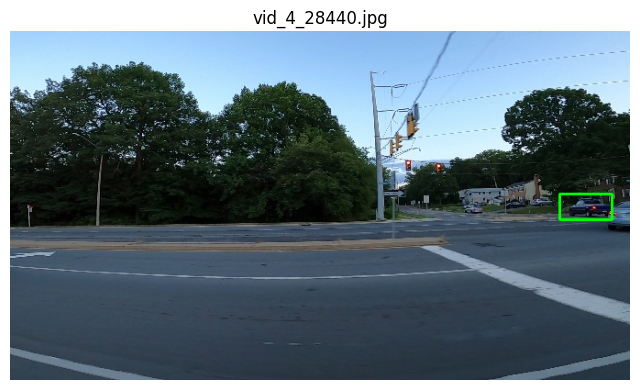

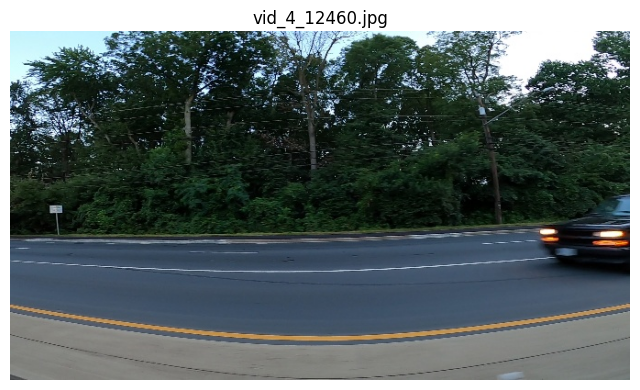

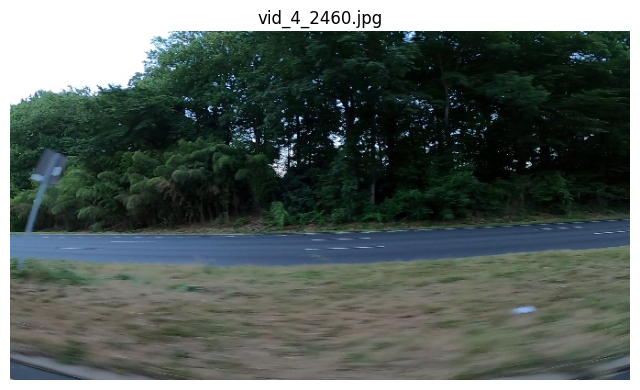

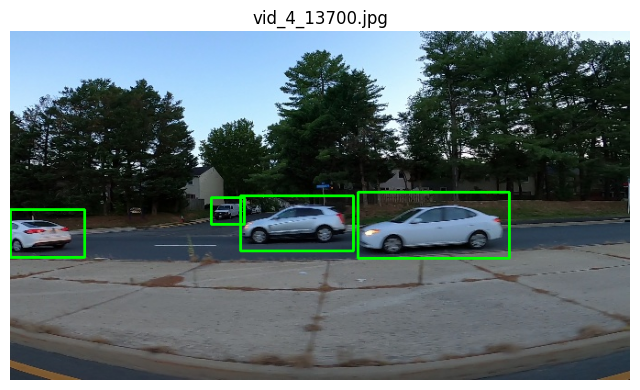

In [9]:
# Plotting sample images with bounding boxes
plot_images_with_boxes(train_data, df)

# Preparing the Dataset for YOLO

In [10]:
# Prepare YOLO format annotations
def create_yolo_annotation(row, img_width, img_height):
    x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
    y_center = ((row['ymin'] + row['ymax']) / 2) / img_height
    width = (row['xmax'] - row['xmin']) / img_width
    height = (row['ymax'] - row['ymin']) / img_height
    return f"0 {x_center} {y_center} {width} {height}"

In [11]:
# Create YOLO annotations and copy images
for img_name in df['image'].unique():
    img_df = df[df['image'] == img_name]
    img_path = os.path.join(train_data, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img_height, img_width = img.shape[:2]
        
        # Decide whether to put in train or val folder
        if np.random.rand() < 0.8:  # 80% train, 20% val
            subset = "train"
        else:
            subset = "val"
        
        # Copy image
        dst_img_path = os.path.join(images_dir, subset, img_name)
        cv2.imwrite(dst_img_path, img)
        
        # Create annotation file
        annotation_path = os.path.join(labels_dir, subset, f"{img_name.split('.')[0]}.txt")
        with open(annotation_path, 'w') as f:
            for _, row in img_df.iterrows():
                yolo_annotation = create_yolo_annotation(row, img_width, img_height)
                f.write(yolo_annotation + '\n')

In [12]:
# Create YAML configuration file
yaml_content = f"""
path: {root_dir}
train: images/train
val: images/val

nc: 1
names: ['car']
"""

with open('car_detection.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML configuration file created.")

YAML configuration file created.


# Training the YOLO Model

In [13]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 101MB/s]


In [14]:
# Disable W&B logging to avoid the API key prompt
os.environ["WANDB_MODE"] = "disabled"

In [15]:
results = model.train(
    data='car_detection.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    name='car_detection_model'
)

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=car_detection.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=car_detection_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/labels/train... 292 images, 0 backgrounds, 0 corrupt: 100%|██████████| 292/292 [00:00<00:00, 1172.31it/s]

train: New cache created: /kaggle/working/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data/labels/val... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 1147.77it/s]

val: New cache created: /kaggle/working/data/labels/val.cache


Plotting labels to runs/detect/car_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/car_detection_model
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.41G      1.504      2.733      1.148          9        640: 100%|██████████| 19/19 [00:04<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         63        103    0.00534      0.981      0.835       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.35G      1.359      1.466      1.099          9        640: 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         63        103     0.0054       0.99      0.288      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.36G      1.346       1.23      1.098          7        640: 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         63        103          1     0.0762      0.755      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.35G      1.325      1.159      1.097         12        640: 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         63        103          1      0.698      0.979       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.36G      1.312      1.098      1.097         17        640: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         63        103      0.949      0.777      0.944       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.36G      1.239      1.048      1.098          7        640: 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         63        103      0.964      0.835       0.93      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.36G      1.247     0.9905      1.085          7        640: 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         63        103      0.899      0.913       0.97      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.37G      1.235     0.9162      1.096         15        640: 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         63        103      0.953       0.99      0.982      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.37G      1.239     0.8828      1.097         17        640: 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         63        103      0.952      0.967      0.988      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.36G      1.169     0.8009      1.059         12        640: 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         63        103      0.955      0.951       0.99       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.36G      1.179     0.7975      1.064         14        640: 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         63        103      0.953       0.98       0.99      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.36G      1.222     0.7792      1.072         10        640: 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         63        103      0.918      0.983      0.989      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.36G      1.194     0.7414      1.053         16        640: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         63        103      0.952      0.942      0.988      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.36G      1.187     0.7286      1.057         16        640: 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         63        103       0.97          1      0.993      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.35G      1.123     0.6903      1.044         11        640: 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         63        103      0.933      0.971      0.988      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.36G      1.128     0.6681      1.029          5        640: 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         63        103      0.965       0.99      0.993      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.36G      1.096     0.6284      1.021         10        640: 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         63        103       0.98      0.957      0.992      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.36G      1.085     0.6183       1.01         11        640: 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         63        103      0.968      0.971      0.993      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.36G       1.09     0.6245      1.015         18        640: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         63        103      0.964      0.981      0.993      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.37G      1.087     0.6125      1.009         12        640: 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         63        103      0.954      0.996      0.993      0.649


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.36G      1.095      0.689       1.04          5        640: 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         63        103      0.968      0.971      0.992       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.36G      1.087     0.6546      1.026          4        640: 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         63        103       0.96      0.981      0.992      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.35G      1.078     0.6443      1.043          5        640: 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         63        103      0.987      0.942      0.991      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.36G      1.053     0.6152      1.027          3        640: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         63        103      0.988      0.961      0.993      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.36G      1.065     0.6226      1.033          4        640: 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         63        103      0.981      0.999      0.994       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.36G     0.9918     0.5877      1.009          5        640: 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         63        103      0.981          1      0.994      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.35G      1.021     0.5935      1.001          4        640: 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         63        103       0.98          1      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.36G     0.9941     0.5828     0.9976          5        640: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         63        103      0.987       0.99      0.995      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.36G     0.9983     0.5703     0.9961          5        640: 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         63        103      0.976          1      0.995      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.36G     0.9936     0.5566     0.9975          4        640: 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         63        103      0.979          1      0.994       0.67



30 epochs completed in 0.038 hours.
Optimizer stripped from runs/detect/car_detection_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/car_detection_model/weights/best.pt, 6.2MB

Validating runs/detect/car_detection_model/weights/best.pt...
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


                   all         63        103      0.981          1      0.994      0.682
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/car_detection_model


# Model Evaluation

In [16]:
# Model Evaluation
results = model.val()
print(results)

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/data/labels/val.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


                   all         63        103      0.981          1      0.994      0.683
Speed: 0.1ms preprocess, 7.0ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/car_detection_model2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9aa808a560>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.03

In [17]:
# Test on a sample image from the test set
sample_test_image = os.path.join(test_data, os.listdir(test_data)[0])

# Perform inference on the sample image
test_results = model(sample_test_image)

# Display the first result using 'plot' or similar method
test_results[0].plot()  # This should display the image with predictions


image 1/1 /kaggle/input/car-object-detection/data/testing_images/vid_5_26420.jpg: 384x640 (no detections), 34.9ms
Speed: 2.6ms preprocess, 34.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [251, 239, 203],
        [251, 239, 203],
        [252, 240, 204]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [251, 239, 203],
        [252, 240, 204],
        [252, 240, 204]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [251, 239, 203],
        [252, 240, 204],
        [252, 240, 204]],

       ...,

       [[ 75, 113, 147],
        [ 75, 113, 147],
        [ 69, 110, 143],
        ...,
        [ 71,  64,  47],
        [ 69,  62,  45],
        [ 70,  66,  48]],

       [[ 73, 103, 128],
        [ 77, 108, 133],
        [ 74, 108, 137],
        ...,
        [ 73,  68,  53],
        [ 70,  65,  50],
        [ 74,  71,  56]],

       [[ 53,  78,  98],
        [ 64,  91, 112],
        [ 68,  99, 124],
        ...,
        [ 71,  66,  51],
        [ 70,  67,  53],
        [ 86,  83,  69]]

___